In [ ]:
# Open up the store and load to xarray

In [ ]:
import icechunk as ic
from icechunk.credentials import S3StaticCredentials
from datetime import datetime
import matplotlib.pyplot as plt
from urllib.parse import urlparse
import earthaccess
from dask.diagnostics import ProgressBar
import xarray as xr

def get_icechunk_creds(daac: str = None) -> S3StaticCredentials:
    if daac is None:
        daac = "PODAAC"  # TODO: Might want to change this for a more general version
        # https://github.com/nsidc/earthaccess/discussions/1051 could help here.
    # assumes that username and password are available in the environment
    # TODO: accomodate rc file?
    auth = earthaccess.login(strategy="environment")
    if not auth.authenticated:
        raise PermissionError("Could not authenticate using environment variables")
    creds = auth.get_s3_credentials(daac=daac)
    return S3StaticCredentials(
        access_key_id=creds["accessKeyId"],
        secret_access_key=creds["secretAccessKey"],
        expires_after=datetime.fromisoformat(creds["expiration"]),
        session_token=creds["sessionToken"],
    )

In [ ]:
store_url = "s3://nasa-eodc-public/icechunk/MUR-JPL-L4-GLOB-v4.1-virtual-v2-p2"
store_url_parsed = urlparse(store_url)

storage = ic.s3_storage(
    bucket = store_url_parsed.netloc,
    prefix = store_url_parsed.path.lstrip('/'),
    from_env=True,
)

repo = ic.Repository.open(
    storage=storage,
)
repo = ic.Repository.open(
    storage=storage,
    authorize_virtual_chunk_access = ic.containers_credentials(
        {
            k: ic.s3_refreshable_credentials(
                    get_credentials=get_icechunk_creds
                ) for k in repo.config.virtual_chunk_containers.keys()
        }
    )
)

session = repo.readonly_session('main')
ds = xr.open_zarr(session.store, zarr_format=3, consolidated=False)
ds

**Note the timesteps ☝️**

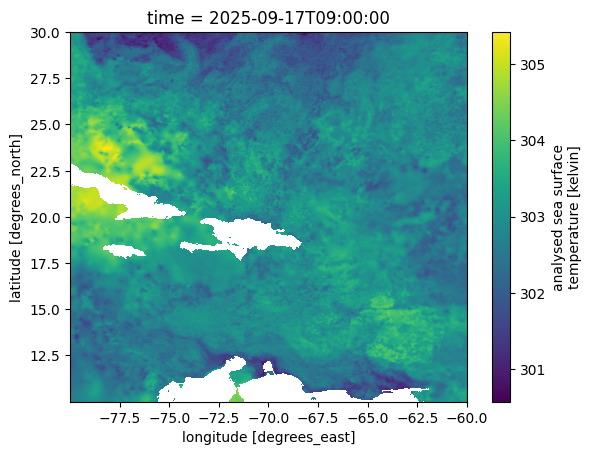

In [4]:
da = ds['analysed_sst'].isel(lon=slice(10000, 12000), lat=slice(10000, 12000))
# plotting the last timestep in the Caribbean
da.isel(time=-1).plot()

[########################################] | 100% Completed | 38.30 s


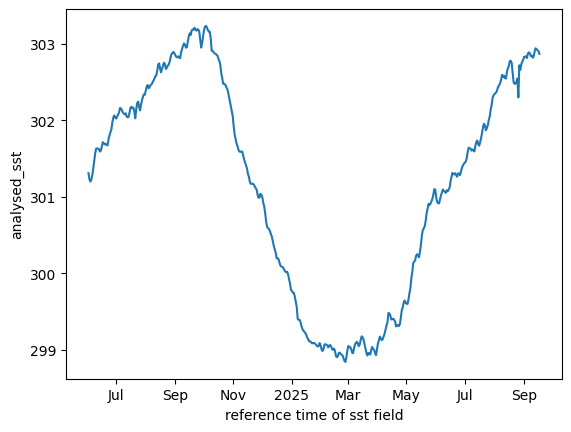

In [5]:
# compute a timeseries
with ProgressBar():
    da.mean(['lon','lat']).plot()

Now I am going to update the store

In [6]:
session = repo.readonly_session('main')
ds_new = xr.open_zarr(session.store, zarr_format=3, consolidated=False)
ds_new

/home/jovyan/mursst-icechunk-updater/.venv/lib/python3.12/site-packages/numcodecs/zarr3.py:145: UserWarning: Numcodecs codecs are not in the Zarr version 3 specification and may not be supported by other zarr implementations.
  super().__init__(**codec_config)


<xarray.Dataset> Size: 9TB
Dimensions:           (time: 475, lat: 17999, lon: 36000)
Coordinates:
  * lat               (lat) float32 72kB -89.99 -89.98 -89.97 ... 89.98 89.99
  * time              (time) datetime64[ns] 4kB 2024-06-02T09:00:00 ... 2025-...
  * lon               (lon) float32 144kB -180.0 -180.0 -180.0 ... 180.0 180.0
Data variables:
    sea_ice_fraction  (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysis_error    (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    mask              (time, lat, lon) float32 1TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
    analysed_sst      (time, lat, lon) float64 2TB dask.array<chunksize=(1, 1023, 2047), meta=np.ndarray>
Attributes: (12/42)
    metadata_link:              http://podaac.jpl.nasa.gov/ws/metadata/datase...
    creator_email:              ghrsst@podaac.jpl.nasa.gov
    acknowledgment:             Please acknowledge the use of these data with...
    easternmost_longitude:      180.0
    geospatial_lat_resolution:  0.009999999776482582
    netcdf_version_id:          4.1
    ...                         ...
    project:                    NASA Making Earth Science Data Records for Us...
    history:                    created at nominal 4-day latency; replaced nr...
    uuid:                       27665bc0-d5fc-11e1-9b23-0800200c9a66
    start_time:                 20240602T090000Z
    publisher_url:              http://www.ghrsst.org
    file_quality_level:         3

**We should have more timesteps now! ☝️**

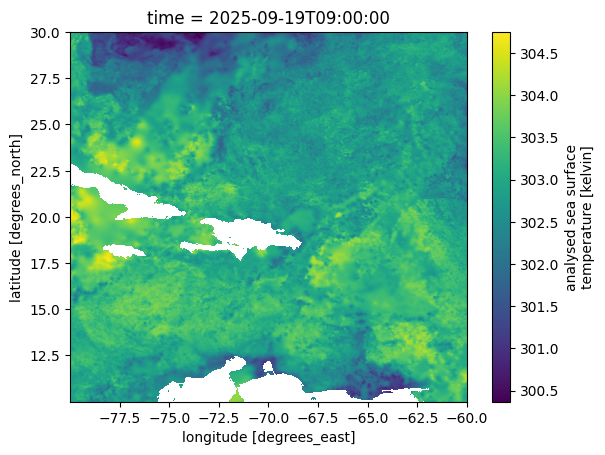

In [7]:
da = ds_new['analysed_sst'].isel(lon=slice(10000, 12000), lat=slice(10000, 12000))
# plotting the last timestep in the Caribbean
da.isel(time=-1).plot()